# Checking for directory

In [2]:
import os

# Get current directory where the notebook is located
notebook_dir = os.getcwd()

# Construct dataset path relative to the notebook directory
dataset_path = os.path.join(notebook_dir, "Humans")

# Check if the directory exists
if not os.path.exists(dataset_path):
    print("Error: Dataset directory not found.")
else:
    print("Dataset directory found:", dataset_path)


Dataset directory found: C:\Users\padhi\Downloads\facedetection\Humans


# Training and Validation Of Humans Dataset after splitting into train test split and analyzing their performance

Epoch 1/10


C:\Users\padhi\ankit.jpynb\Lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


178/178 [==============================] - 806s 4s/step - loss: 0.0040 - accuracy: 0.9977 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
178/178 [==============================] - 1087s 6s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
178/178 [==============================] - 1412s 8s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
178/178 [==============================] - 2152s 12s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
178/178 [==============================] - 1292s 7s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
178/178 [==============================] - 912s 5s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
178/178 [==============================] - 706s 4s/step - loss: 0.0000e+00 - accuracy: 1.0000

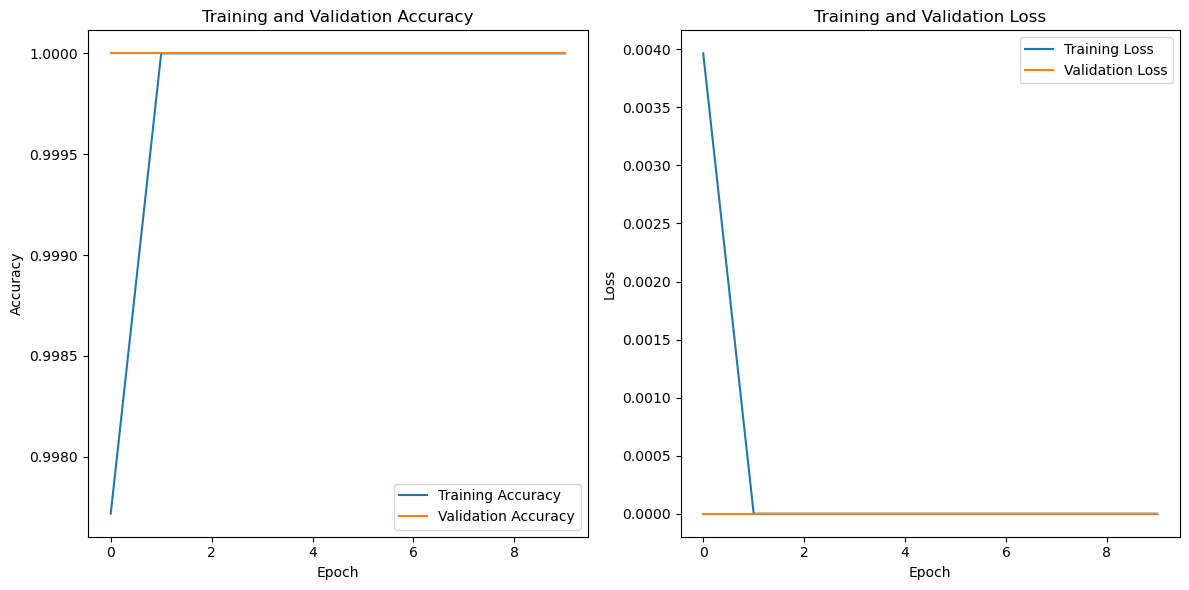

In [4]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from imutils.object_detection import non_max_suppression
from PIL import Image

# Function to preprocess image
def preprocess_image(image_path, target_size=(227, 227)):
    image = load_img(image_path, target_size=target_size)
    
    # Convert image to RGBA if it has transparency
    if image.mode != 'RGB':
        image = image.convert('RGBA')
        background = Image.new('RGB', image.size, (255, 255, 255))
        background.paste(image, mask=image.split()[3])  # 3 is the alpha channel
        image = background
    
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    return image

# Function to load image paths from dataset directory
def load_image_paths(dataset_path):
    image_paths = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(".jpg") or file.endswith(".png"):  # Adjust file extensions as needed
                image_paths.append(os.path.join(root, file))
    return image_paths

# Define the AlexNet-like architecture
inputs = Input(shape=(227, 227, 3))

x = Conv2D(96, (11, 11), strides=(4, 4), activation='relu')(inputs)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

x = Conv2D(256, (5, 5), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

x = Conv2D(384, (3, 3), padding='same', activation='relu')(x)
x = Conv2D(384, (3, 3), padding='same', activation='relu')(x)
x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dense(4096, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=predictions)

# Compile the model with the optimizer using learning_rate
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Set dataset path
dataset_path = 'Humans'  # Change this to your dataset path

# Load image paths
image_paths = load_image_paths(dataset_path)

# Split data into train and validation sets
train_image_paths, val_image_paths = train_test_split(image_paths, test_size=0.2, random_state=42)

# Define batch size
batch_size = 32

# Function to generate batches of preprocessed images
def image_generator(image_paths, batch_size=32):
    num_samples = len(image_paths)
    while True:
        for i in range(0, num_samples, batch_size):
            batch_paths = image_paths[i:i+batch_size]
            batch_images = [preprocess_image(path) for path in batch_paths]
            batch_images = np.concatenate(batch_images, axis=0)  # Concatenate along the batch axis
            batch_labels = [1] * len(batch_images)  # Assuming all images contain faces
            yield batch_images, np.array(batch_labels)  # Yield batch as numpy array

# Create image generators
train_generator = image_generator(train_image_paths, batch_size=batch_size)
val_generator = image_generator(val_image_paths, batch_size=batch_size)

# Calculate steps per epoch
train_steps_per_epoch = len(train_image_paths) // batch_size
val_steps_per_epoch = len(val_image_paths) // batch_size

# Train the model using generator
history = model.fit(train_generator, steps_per_epoch=train_steps_per_epoch, epochs=10, validation_data=val_generator, validation_steps=val_steps_per_epoch)

# Plot training history
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

20/44 [============>.................] - ETA: 32s

C:\Users\padhi\ankit.jpynb\Lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


44/44 [==============================] - 62s 1s/step


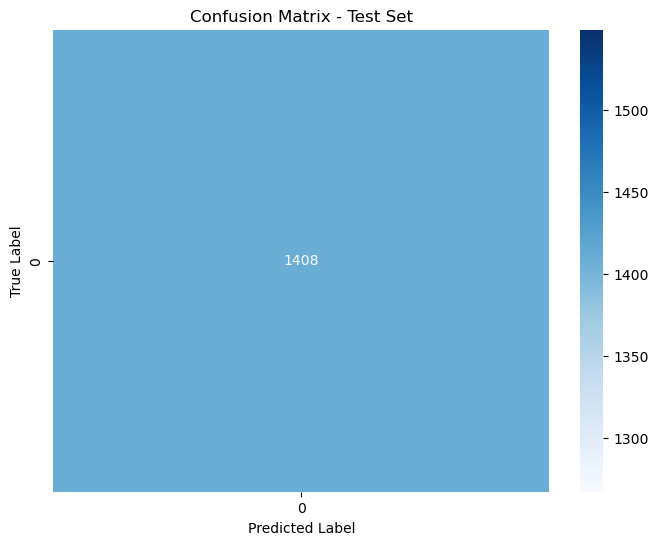


Classification Report - Test Set:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


C:\Users\padhi\ankit.jpynb\Lib\site-packages\sklearn\metrics\_ranking.py:1123: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


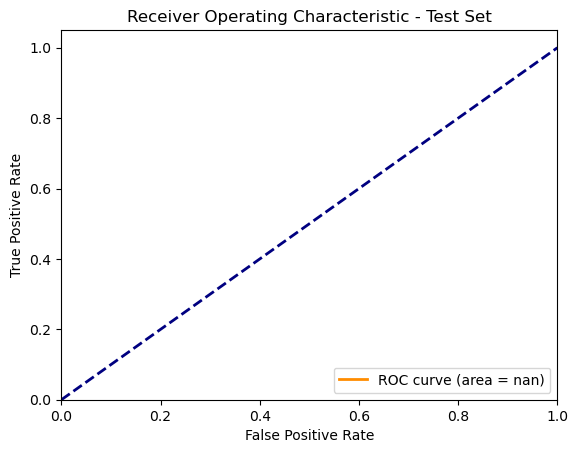

In [10]:
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc



# Split the data into train, validation, and test sets
train_image_paths, val_test_image_paths = train_test_split(image_paths, test_size=0.4, random_state=42)
val_image_paths, test_image_paths = train_test_split(val_test_image_paths, test_size=0.5, random_state=42)

# Define batch size for the test set
test_batch_size = 32

# Function to generate batches of preprocessed images for the test set
def test_image_generator(image_paths, batch_size=32):
    num_samples = len(image_paths)
    while True:
        for i in range(0, num_samples, batch_size):
            batch_paths = image_paths[i:i+batch_size]
            batch_images = [preprocess_image(path) for path in batch_paths]
            batch_images = np.concatenate(batch_images, axis=0)  # Concatenate along the batch axis
            batch_labels = [1] * len(batch_images)  # Assuming all images contain faces
            yield batch_images, np.array(batch_labels)  # Yield batch as numpy array

# Create a generator for the test set
test_generator = test_image_generator(test_image_paths, batch_size=test_batch_size)

# Calculate steps per epoch for the test set
test_steps_per_epoch = len(test_image_paths) // test_batch_size

# Make predictions on the test set
test_predictions = model.predict(test_generator, steps=test_steps_per_epoch)

# Convert predicted probabilities to binary labels based on a threshold
threshold = 0.5
binary_predictions_test = (test_predictions > threshold).astype(int)

# Assuming you have the true labels for the test set, calculate them accordingly
test_true_labels = [1] * len(test_image_paths)  # Modify this based on your actual test set labels

# Trim test_true_labels to match the length of binary_predictions_test
test_true_labels = test_true_labels[:len(binary_predictions_test)]

# Calculate confusion matrix
conf_matrix_test = confusion_matrix(test_true_labels, binary_predictions_test)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Set')
plt.show()

# Calculate classification metrics
accuracy_test = accuracy_score(test_true_labels, binary_predictions_test)
precision_test = precision_score(test_true_labels, binary_predictions_test)
recall_test = recall_score(test_true_labels, binary_predictions_test)
f1_test = f1_score(test_true_labels, binary_predictions_test)

# Display classification report
print("\nClassification Report - Test Set:")
print("Accuracy:", accuracy_test)
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1 Score:", f1_test)

# Plot ROC curve
fpr_test, tpr_test, thresholds_test = roc_curve(test_true_labels, test_predictions)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Test Set')
plt.legend(loc="lower right")
plt.show()

# PREDICTION FOR TEST IMAGES USING OPENCV AND MATTPLOTLIB AND OBTAINING PROBABILITY TAGGING FOR DETECTED FACES 

1/1 [==============================] - 0s 369ms/step


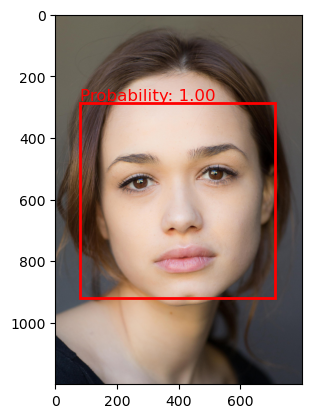

1/1 [==============================] - 0s 85ms/step


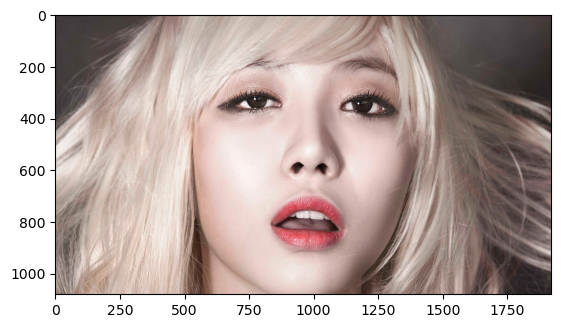

1/1 [==============================] - 0s 89ms/step


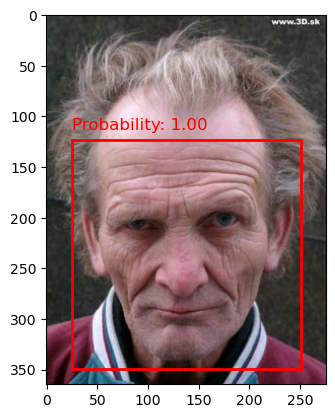

1/1 [==============================] - 0s 67ms/step


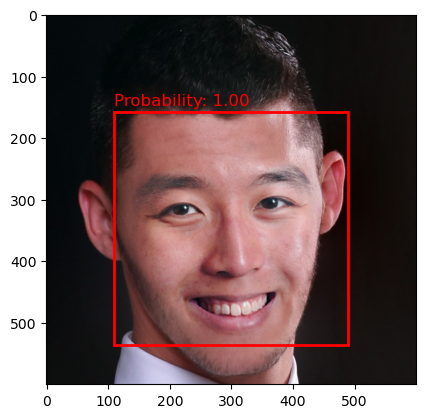

1/1 [==============================] - 0s 131ms/step


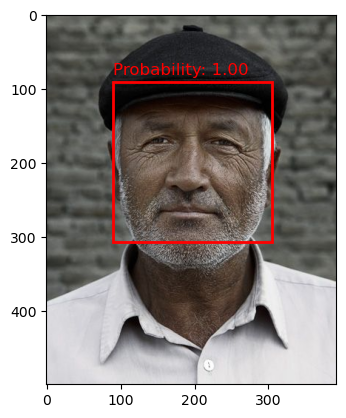

In [11]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Function to preprocess image
def preprocess_image(image_path, target_size=(227, 227)):
    image = cv2.imread(image_path)
    image = cv2.resize(image, target_size)
    image = image.astype('float') / 255.0
    image = np.expand_dims(image, axis=0)
    return image

# Load the pre-trained Haar Cascade classifier for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Function to detect faces in an image and return their coordinates
def detect_faces(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    return faces


# Function to display images from the test set with probability tagging for detected faces
def display_images_with_tags_and_predictions(image_paths, model, threshold=0.5, num_images=5):
    for i, image_path in enumerate(image_paths[:num_images]):
        image = cv2.imread(image_path)
        preprocessed_image = preprocess_image(image_path)
        
        # Predict probability for the image
        prediction_prob = model.predict(preprocessed_image)[0][0]
        
        # Detect faces in the image
        faces = detect_faces(image)
        
        # Draw rectangles and display probability tagging for detected faces
        plt.figure()
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        ax = plt.gca()
        
        for (x, y, w, h) in faces:
            rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            plt.text(x, y - 10, f"Probability: {prediction_prob:.2f}", color='r', fontsize=12)
            
        plt.show()

# Display images from the test set with probability tagging for detected faces
display_images_with_tags_and_predictions(test_image_paths, model, threshold=0.5, num_images=5)


# DISPLAYING HEATMAP OF GENERATED IMAGES

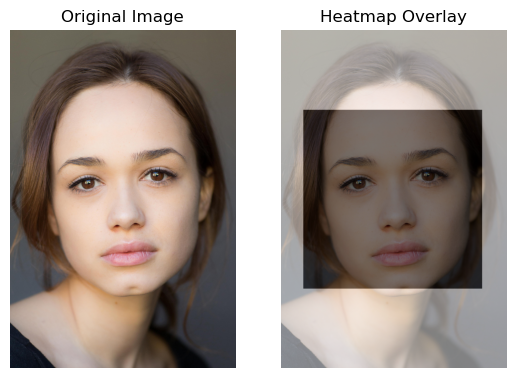

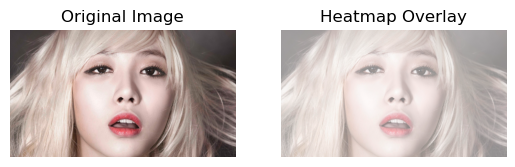

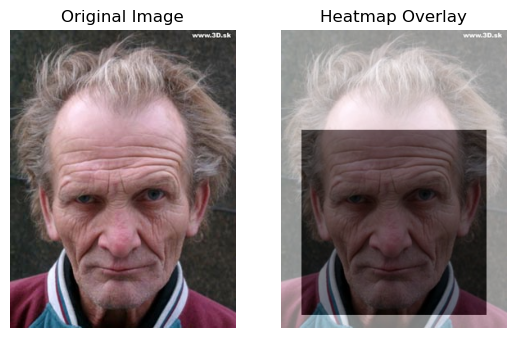

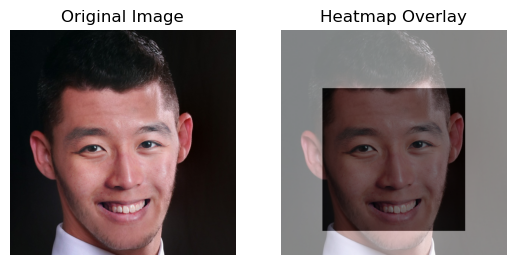

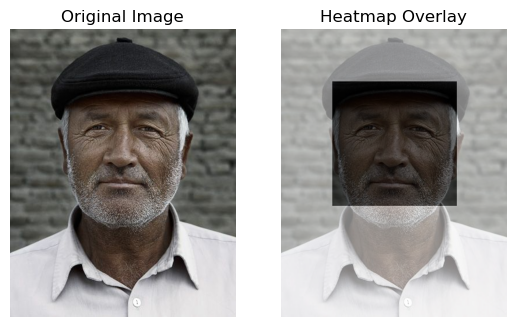

In [12]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Function to preprocess image
def preprocess_image(image_path, target_size=(227, 227)):
    image = cv2.imread(image_path)
    image = cv2.resize(image, target_size)
    image = image.astype('float') / 255.0
    image = np.expand_dims(image, axis=0)
    return image

# Load the pre-trained Haar Cascade classifier for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Function to detect faces in an image and return their coordinates
def detect_faces(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    return faces

# Function to generate and overlay masked heatmaps for detected faces in images
def generate_and_overlay_heatmaps(image_paths):
    for i, image_path in enumerate(image_paths[:5]):
        image = cv2.imread(image_path)
        preprocessed_image = preprocess_image(image_path)
        
        # Detect faces in the image
        faces = detect_faces(image)
        
        # Create a blank heatmap
        heatmap = np.zeros_like(image[:, :, 0], dtype=np.uint8)
        
        # Add intensity to face regions in the heatmap
        for (x, y, w, h) in faces:
            heatmap[y:y+h, x:x+w] = 255
        
        # Invert the heatmap to highlight face regions
        heatmap = cv2.bitwise_not(heatmap)
        
        # Overlay the masked heatmap onto the original image
        overlay = cv2.addWeighted(image, 0.5, cv2.cvtColor(heatmap, cv2.COLOR_GRAY2BGR), 0.5, 0)
        
        # Display the original image and the overlay
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
        plt.title('Heatmap Overlay')
        plt.axis('off')
        
        plt.show()

# Generate and overlay masked heatmaps for detected faces in the test images
generate_and_overlay_heatmaps(test_image_paths)
